In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from random import sample
import seaborn as sns

from statsmodels import regression
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

plt.rcParams["figure.figsize"] = (15,7)
np.random.seed(107)

[*********************100%***********************]  1 of 1 completed
                 Date        MSFT
Date                             
2020-08-03 2020-08-03  214.958664
2020-08-04 2020-08-04  211.732391
2020-08-05 2020-08-05  211.384949
2020-08-06 2020-08-06  214.770050
2020-08-07 2020-08-07  210.928314
...               ...         ...
2020-12-24 2020-12-24  222.238144
2020-12-28 2020-12-28  224.443069
2020-12-29 2020-12-29  223.634918
2020-12-30 2020-12-30  221.170593
2020-12-31 2020-12-31  221.908905

[106 rows x 2 columns]


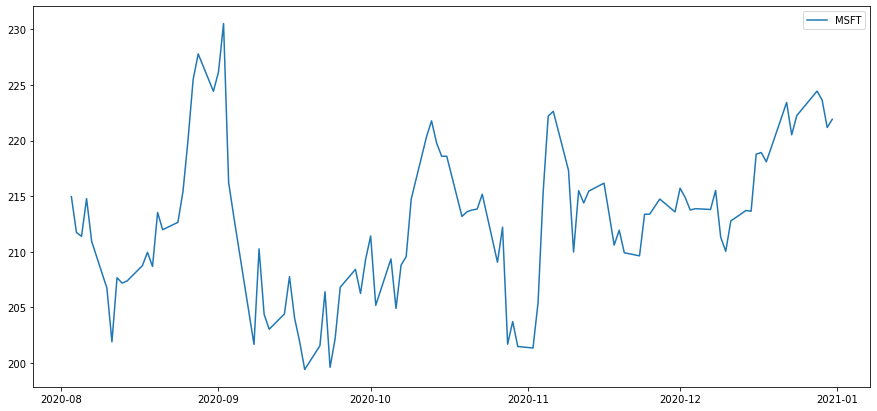

In [2]:
#Plot Microsoft's closing prices
start = "2020-8-01"
end = "2021-01-01"
ticker = "MSFT"
data = yf.download(tickers=ticker, start=start, end=end, interval = "1d")
price = pd.DataFrame()
price['Date'] = data.index.to_series() #data['Date']
price[ticker] = data['Adj Close']
print(price)
plt.plot(price['Date'], price[ticker], label = ticker)
plt.legend()

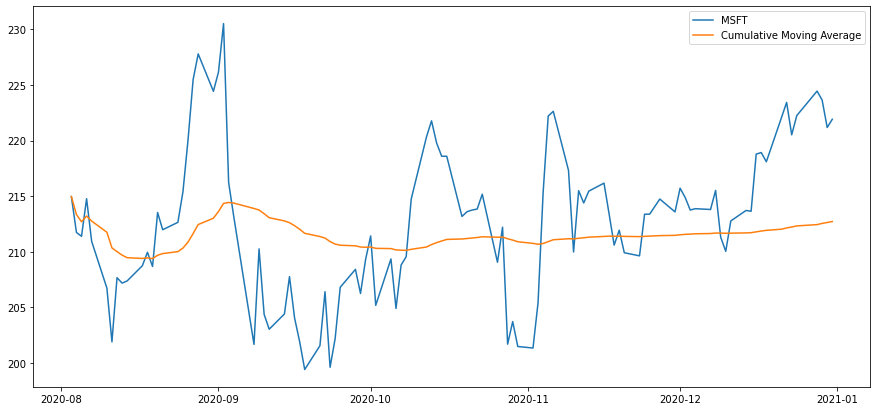

In [3]:
# Calculate Microsoft's CMA for the time-series generated above. Plot the CMA along with the closing prices
plt.figure(figsize=(15,7))
plt.plot(price['Date'], price[ticker], label = ticker)
X = np.arange(len(price['Date']))
price['cma'] = price[ticker].cumsum()/(X+1)
plt.plot(price['Date'], price['cma'], label = 'Cumulative Moving Average')
plt.legend()

<ipython-input-4-7a55da56028a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  zscores = [(price[ticker][i] - price['cma'][i]) / np.std(price[ticker][:i]) for i in range(len(price))]


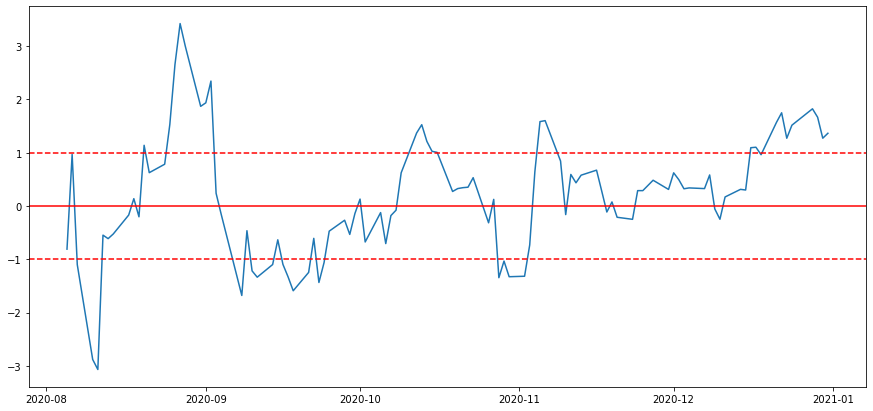

In [4]:
# Calculate the rolling z-score
zscores = [(price[ticker][i] - price['cma'][i]) / np.std(price[ticker][:i]) for i in range(len(price))]

# Plot the rolling z-scores to the corresponding day
price['zscore'] = zscores
plt.plot(price['Date'], price['zscore'])

# These plots represent z-scores of 0, 1 and -1 which represent the location of the normalized mean and 
# standard deviation of the rolling z-score
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=-1, color='r', linestyle='--')

### Question 2

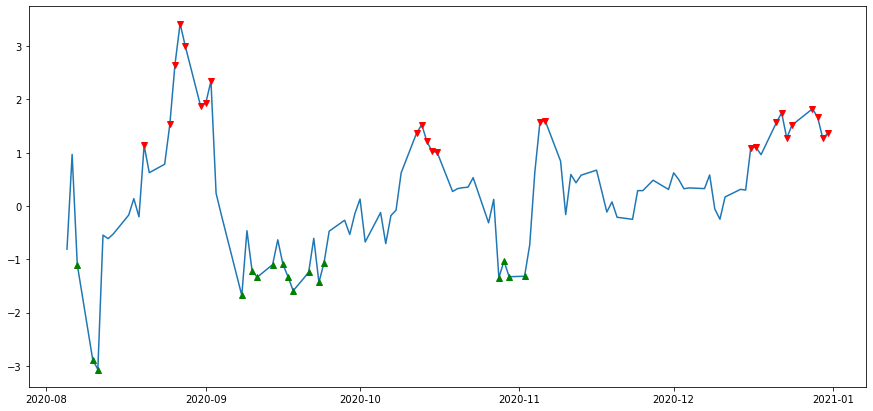

In [5]:
# Generate signals according to trading strategy described above
buy_signal = price[price["zscore"] < -1]# Create Buy Signal by filtering for zscore less than -1 

sell_signal = price[price["zscore"] > 1]# Create Sell Signal by filtering for zscore greater than 1

plt.plot(price['Date'], price['zscore'])
plt.plot(buy_signal['Date'], buy_signal['zscore'], linestyle='None', marker='^', color='g')
plt.plot(sell_signal['Date'], sell_signal['zscore'], linestyle='None', marker='v', color='r')

In [6]:
# Elementary trading strategy for testing yield
money = 0
count = 0
for i in range(len(price)):
    # Sell short if the z-score is > 1
    if zscores[i] > 1:
        money += price[ticker][i]
        count -= 1
    # Buy long if the z-score is < 1
    elif zscores[i] < -1:
        money -= price[ticker][i]
        count += 1
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscores[i]) < 0.5:
        money += count*price[ticker][i]
        count = 0
print(money)

2413.2879791259766


In [7]:
# Sample 100 stocks and store their closing prices for month of January 2021 in a variable called prices
print(len(tickers))
samples = sample(tickers,100)
start = "2021-1-01"
end = "2021-1-31"
data = yf.download(tickers=samples, start=start, end=end, interval = "1d")
prices = data['Adj Close'].dropna(axis=1)

# Plot the daily returns
returns = prices/prices.shift(-1) -1
returns.plot()

NameError: name 'tickers' is not defined

These kind of plots don't help us understand the mean reverting nature of these stock prices. So we will try another commonly used method of ranking the stocks according their returns.

We believe that the stocks which do well for the first week will regress after another month, while those which do poorly at first will appreciate in value. In line with this hypothesis, for each stock you will find returns for the first week and returns for the rest of the month. Then you will rank them according to their weeekly return, with 0 being the lowest weekly return. You will perform this ranking using the `argsort` method.



In [8]:
# vals is an array of closing prices for  for each day
vals = np.array(prices)
print(vals.shape)
# print(prices.head)

# For each security, take the return for the first week
wreturns = vals[3,:]/vals[0,:] - 1 # 1st couple of days have missing data, so first week corresponds to 1st 4 rows
# print(wreturns)

# For each security, take the return for the month following the first week
mreturns = vals[-1,:]/vals[4,:] - 1
# print(mreturns)

# Rank securities by return, with 0 being the lowest weekly return
# Hint: use argsort twice
order = np.argsort(wreturns)
ranks = np.argsort(order)

# Plot the returns for the first week vs returns for the next month to visualize them
plt.figure(figsize=(15,7))
plt.scatter(wreturns, mreturns)
plt.plot(np.unique(wreturns), np.poly1d(np.polyfit(wreturns, mreturns, 1))(np.unique(wreturns)))
plt.xlabel('Returns for the first week')
plt.ylabel('Returns for the following month')

NameError: name 'prices' is not defined

In [9]:
# Go long (by one share each) in the bottom 20% of securities and short in the top 20%
longs = np.array([int(x < 20)for x in ranks])
shorts = np.array([int(x > 70) for x in ranks])
print('Going long in:', [samples[i] for i in range(len(prices.columns)) if longs[i]])
print('Going short in:', [samples[i] for i in range(len(prices.columns)) if shorts[i]])

# Resolve all positions and calculate how much we would have earned
print('Yield:', sum((vals[-1] - vals[4])*(longs - shorts)))

NameError: name 'ranks' is not defined

<h1> Pairs trading </h1>


In [150]:
# Sample 10 stocks from the S&P 500
tickers = ['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AAP', 'AMD', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'BIIB', 'BLK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CPRT', 'GLW', 'CTVA', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DTE', 'DUK', 'DRE', 'DD', 'DXC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ENPH', 'ETR', 'EOG', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'RE', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FRC', 'FE', 'FISV', 'FLT', 'FLIR', 'FLS', 'FMC', 'F', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GS', 'GWW', 'HAL', 'HBI', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HES', 'HPE', 'HLT', 'HFC', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUM', 'HBAN', 'HII', 'IEX', 'IDXX', 'INFO', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IBM', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'IPGP', 'IQV', 'IRM', 'JBHT', 'JKHY', 'J', 'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LB', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LEG', 'LDOS', 'LEN', 'LLY', 'LNC', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LUMN', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MXIM', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NWL', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NSC', 'NTRS', 'NOC', 'NLOK', 'NCLH', 'NOV', 'NRG', 'NUE', 'NVDA', 'NVR', 'ORLY', 'OXY', 'ODFL', 'OMC', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'QCOM', 'PWR', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STE', 'SYK', 'SIVB', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'BK', 'CLX', 'COO', 'HSY', 'MOS', 'TRV', 'DIS', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRMB', 'TFC', 'TWTR', 'TYL', 'TSN', 'USB', 'UDR', 'ULTA', 'UAA', 'UA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'UNM', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VIAC', 'VTRS', 'V', 'VNT', 'VNO', 'VMC', 'WRB', 'WBA', 'WMT', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WU', 'WAB', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']
samples = sample(tickers,50)
print(samples)

['TRMB', 'CRM', 'AMAT', 'CHRW', 'VNT', 'NEE', 'VIAC', 'DISH', 'BIIB', 'IP', 'AKAM', 'CMS', 'AJG', 'CSX', 'TPR', 'URI', 'MAS', 'DXCM', 'WST', 'LIN', 'LUMN', 'AAP', 'UAA', 'EXPD', 'NUE', 'OMC', 'ZBRA', 'MTD', 'EMN', 'FTV', 'IPGP', 'KHC', 'QCOM', 'MRO', 'HD', 'LNT', 'ALLE', 'STX', 'ALB', 'GPN', 'CTAS', 'DXC', 'V', 'LMT', 'AOS', 'MPC', 'CNP', 'CMG', 'UNH', 'LEG']


In [151]:
# Find their closing prices for the last three years from 2017-01-01 to 2021-01-01.
# Store this in a variable called prices
start = "2016-04-01"
end = "2021-04-01"
oil_samples = ["XOM","CVX","COP","OXY","KMI","HAL"]
data = yf.download(tickers=samples, start=start, end=end, interval = "1d")
oil_data = yf.download(tickers = "XOP", start=start, end=end, interval = "1d")
prices = data['Adj Close'].dropna(axis=1)
prices


[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


,AAP,AJG,AKAM,ALB,ALLE,AMAT,AOS,BIIB,CHRW,CMG,...,STX,TPR,TRMB,UAA,UNH,URI,V,VIAC,WST,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-01,157.947067,39.858620,55.220001,60.443031,62.254620,19.980734,36.022903,260.540009,65.550713,464.809998,...,25.171064,34.772808,25.049999,42.349998,120.152176,60.810001,75.042480,50.457943,68.753258,68.150002
2016-04-04,156.775436,39.688931,55.330002,60.563549,61.759487,19.747534,35.633823,264.010010,65.390480,465.000000,...,25.066465,34.455292,25.040001,41.689999,119.754463,59.470001,75.274597,50.137833,68.168671,66.709999
2016-04-05,157.996338,39.054840,53.139999,59.794121,61.607124,19.542315,35.647724,265.619995,65.443886,463.420013,...,24.550945,34.077694,25.100000,41.770000,117.488678,58.480000,74.442848,49.625656,67.593864,65.720001
2016-04-06,157.415405,39.295971,54.779999,61.212505,63.044945,19.644924,36.143341,279.570007,65.559616,455.250000,...,25.193478,34.584015,25.139999,42.919998,118.404251,59.000000,75.642136,50.165272,68.022522,66.790001
2016-04-07,153.427856,38.786900,53.279999,59.970264,60.912022,19.402391,35.564342,273.040009,63.948643,450.600006,...,24.737726,34.592594,24.490000,42.985001,117.331474,57.950001,75.032814,49.003754,67.116478,65.980003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,185.649994,124.959999,99.540001,148.929993,123.480003,119.720001,66.730003,273.970001,96.279999,1431.829956,...,72.980003,41.820000,72.290001,22.440001,371.089996,314.239990,207.970001,66.349998,275.302185,461.260010
2021-03-26,187.320007,125.699997,102.699997,150.399994,126.750000,128.639999,69.489998,276.630005,97.699997,1445.479980,...,76.019997,41.799999,74.699997,22.360001,376.480011,329.859985,213.529999,48.230000,280.159576,476.959991
2021-03-29,185.059998,126.839996,103.099998,146.410004,126.279999,125.709999,69.220001,276.079987,97.410004,1424.609985,...,75.230003,39.490002,75.279999,21.459999,379.059998,324.470001,214.509995,45.009998,280.359497,467.070007


In [152]:
oil = pd.read_csv('https://raw.githubusercontent.com/LDeng0205/Pairs-Trading-with-Macroeconomic-Data-Analysis/master/oil-data/DCOILWTICO.csv')

oil


,DATE,DCOILWTICO
0,2016-04-19,40.88
1,2016-04-20,42.72
2,2016-04-21,43.18
3,2016-04-22,42.76
4,2016-04-25,41.67
...,...,...
1300,2021-04-13,60.2
1301,2021-04-14,63.15
1302,2021-04-15,63.42
1303,2021-04-16,63.16


In [143]:
# Uses to coint method to find cointegration for each pair in the sample
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [144]:
# This might take a minute
scores, pvalues, pairs = find_cointegrated_pairs(prices)
sns.heatmap(pvalues, xticklabels=samples, yticklabels=samples, cmap='RdYlGn_r' , mask = (pvalues >= 0.98))
plt.show()
print(pairs)

KeyboardInterrupt: 

Conduct some analysis make sure nothing weird is going on 

In [ ]:
# Set ticker1 and ticker2 to the stocks you've identified.
ticker1 = "ABBV"# Set ticker1
ticker2 = "TTWO"# Set ticker2
S1 = prices[ticker1]
S2 = prices[ticker2]
score, pvalue, _ = coint(S1, S2)
print(pvalue)

ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

<h3> Generating signals </h3>

Before we proceed to generate signals, we will split the sample into training and testing sets. Generally, two thirds of the dataset is used to train and remaining is used to test.

In [ ]:
# Find the test-train split using the length of 'ratios'
2/3 * len(ratios)

In [ ]:
split_number = round(2/3 * len(ratios))# Insert above number
train = ratios[:split_number]
test = ratios[split_number:]
print(ratios)

With mean reversion, we generated signals by computing the rolling z-score of the closing price against its expected price (CMA).

Initially, we defined the z-score as $$z = \frac{\text{Closing price at day i - Cumulative Moving average at day i}}{\text{Standard deviation of the closing prices till day i}}$$

However, for pairs trading, we're dealing with a larger time-series and we're using a ratio of stock prices instead of just closing prices. This means we have to update this definition using rolling windows. 

Why? 

For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling/moving windows of the most recent data.

We'll use a 5 Day moving average to represent the observed value $x$. 

We'll use the 60 Day moving average to represent the expected expected value ${\mu}$.

We'll use the 60 Day standard deviation to represent the standard deviation ${\sigma}$. 

Hence the rolling z-score will look like:

$$z = \frac{\text{MAvg_5 - MAvg_60}}{\text{Std_60}}$$

In [ ]:
# Compute the rolling z-score of the ratio using the definition above
# Hint: Use pandas.Series.rolling on your training set. Set center = false

ratios_mavg5 = ratios.rolling('5d',center = False).mean() 
# print(ratios_mavg5)

ratios_mavg60 = ratios.rolling('60d',center = False).mean() 
# print(ratios_mavg60)

std_60 = ratios.rolling('60d',center = False).std()
# print(std_60)

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
print(zscore_60_5)

In [ ]:
# This plots the moving averages you calculated. Notice how longer windows smoothen out the curves.

plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

In [ ]:
# This plot the rolling z-score of the ratio

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In [ ]:
#Generate signals using the previously defined trading strategy

plt.figure(figsize=(15,7))
train[60:].plot()

buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0 
sell[zscore_60_5<1] = 0

buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

What do these signals mean for actual stocks that we are trading? Let’s take a look

In [ ]:
plt.figure(figsize=(18,9))
S1 = prices[ticker1].iloc[:671]
S2 = prices[ticker2].iloc[:671]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend([ticker1,ticker2, 'Buy Signal', 'Sell Signal'])
plt.show()

In [ ]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
    return money

In [ ]:
trade(prices[ticker1].iloc[:split_number], prices[ticker2].iloc[:split_number], 5, 60)

In [ ]:
trade(prices[ticker1].iloc[split_number:], prices[ticker2].iloc[split_number:], 5, 60)

In [ ]:
# Check with training data
length_scores = [trade(prices[ticker1].iloc[:split_number], 
                prices[ticker2].iloc[:split_number], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)
print('Money made:', length_scores[best_length])

In [ ]:
# Check with testing data
length_scores2 = [trade(prices[ticker1].iloc[671:], 
                  prices[ticker2].iloc[671:],5, l) 
                  for l in range(255)]

best_length2 = np.argmax(length_scores2)
print ('Best window length:', best_length2)
print('Money made:', length_scores2[best_length2])